<a href="https://colab.research.google.com/github/storimaging/Notebooks/blob/main/ContrastAndColor/TP_Radiometrie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to image processing - Radiometry

## Introduction

Radiometry is a set of techniques for measuring electromagnetic radiation, including visible light. 
In this practical session we will work with histograms to describe the frequency with which the intensity values (pixels) of an image occur. It also shows how to modify image contrasts using histograms. Finally, Image Quantization techniques are shown, especially useful for displaying images on screen with different color depth.

For some parts of the session (cells with commands written as `todo_something`...), you are supposed to code by yourself.

**Authors:**
* [Julie Delon](https://github.com/judelo)
* Lucía Bouza

## Importing packages

Below is a list of packages needed and a brief explanation of its use in this notebook:

- `numpy` (library used for working with arrays)
- `matplotlib` (library used for working with images)
-  `os` (library used for interact with the operating system)

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os

The following line will be used to import the solutions of the practical session. Do not use it for the moment.

In [7]:
#@title
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans  # for kmeans


#############
# computing and displaying histograms
#############

def comp_histos(im):
    
    imhisto, bins = np.histogram(im, range=(0,1), bins = 256)
    imhisto       = imhisto/np.sum(imhisto)
    imhistocum = np.cumsum(imhisto)
    
    return imhisto, bins, imhistocum

def plot_histos(im):
    
    imhisto, bins, imhistocum = comp_histos(im)
    values = (bins[1:]+bins[:-1])/2
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    axes[0].imshow(im,cmap='gray',vmin=0,vmax=1)
    axes[1].bar(values,imhisto,width=1/256)
    axes[1].set_title('histogram')
    axes[2].bar(values,imhistocum,width=1/256)
    axes[2].set_title('cumulative histogram')
    fig.tight_layout()
    plt.show()

#############
# histogram equalization
#############

def todo_equalization(imrgb):

    if (len(imrgb.shape)==3):
        imgray = 1/3*(imrgb[:,:,0]+imrgb[:,:,1]+imrgb[:,:,2])
    else:
        imgray = imrgb
    [nrow,ncol] = imgray.shape
        
    imhisto,bins= np.histogram(imgray, range=(0,1), bins = 256)
    imhisto      = imhisto/np.sum(imhisto)
    imhistocum = np.cumsum(imhisto)

    imeq = imhistocum[np.uint8(imgray*255)]
    imeq=imeq.reshape(nrow,ncol)
    
    return imeq

#############
# noise on histograms
#############

def add_gaussian_noise(u,sigma):
    
    nrow, ncol = u.shape
    res = u + sigma * np.random.randn(nrow,ncol)
    res = np.maximum(0,np.minimum(1,res))
    
    return res


def todo_noise_histograms(imgray):
    
    for sigma in [0,0.1,0.5]:
        imgray_noise = add_gaussian_noise(imgray,sigma)
        plot_histos(imgray_noise)

def add_uniform_noise(u,sigma):
    
    alpha = np.sqrt(3)*sigma
    nrow, ncol = u.shape
    res = u + (np.random.rand(nrow,ncol)-.5)*2*alpha
    res = np.maximum(0,np.minimum(1,res))
    
    return res

def todo_uniform_noise_histograms(imgray):
    
    for sigma in [0,0.1,0.5]:
        imgray_noise = add_uniform_noise(imgray,sigma)
        plot_histos(imgray_noise)


def add_impulse_noise(u,p):
    
    nrow, ncol = u.shape
    Y = np.random.rand(nrow,ncol)
    tab = np.random.rand(nrow,ncol)
    X = np.zeros((nrow,ncol))
    X[tab<p] = 1
    res = (1-X)*u+X*Y
    return res

def todo_impulse_noise_histograms(imgray):
    
    for p in [0,.25,.5]:
        imgray_noise = add_impulse_noise(imgray,p)
        plot_histos(imgray_noise)



##################
#### quantization and dithering
##################

# we define a function to perform the quantization of an image u given the values of t_i and q_i :
def quantize(u,t,q):
    K = len(q)
    u_quant = np.zeros(u.shape)
    for k in range(K):
        test = (u>=t[k])
        u_quant[test] = q[k]
    return u_quant

def todo_histogram_quantize(u,K):
    nrow, ncol = u.shape
    # we need to compute t_i = H_u^-1(i/K)
    # First we sort the values of u:
    S_u = np.sort(u,axis=None)
    # S_u gives the sorted values of u. We have S_u[j]=lambda <=> j/|Omega| = H_u(lambda)
    # So we have : t_i = H_u^-1(i/K) = S_u[|Omega|*i/K]
    # So first we need to compute the indices j = |Omega|*i/K for i=0,1,...,K :
    tab_i = np.arange(K+1)/K
    tab_j = ((nrow*ncol-1)*tab_i).astype(int)
    # now we compute the t_i = S_u[j]
    t = S_u[tab_j]
    # finally we compute the q_i = (t_{i+1}+t_i)/2 :
    q = .5 * (t[1:]+t[:-1])
    # finally we compute the quantization given t and q :
    u_quant = quantize(u,t,q)
    return u_quant


def todo_Lloyd_Max_quantize(u,K,plot=False):
    imhisto, bins, imhistocum = comp_histos(u)
    imcumesp = np.cumsum(np.arange(256)*imhisto/256)
    t = np.arange(K+1)/K
    test = True
    eps = 1e-6
    k = 0
    while test:
        k+=1
        indt = (255*t).astype(np.int32)
        q = np.diff(imcumesp[indt]) / np.diff(imhistocum[indt])
        t_old = t.copy()
        t[1:-1] = .5 * (q[1:]+q[:-1])
        test = (np.linalg.norm(t-t_old) > eps)
    if K==2:
        # N.B. we prefer to use values 0 and 1 for a binary image
        q[0], q[1] = 0, 1
    u_quant = quantize(u,t,q)
    if plot:
        plt.figure(figsize=(16, 7))
        plt.subplot(1,2,1)
        plt.title('Lloyd-Max quantization with ' + str(K) + ' levels')
        plt.imshow(u_quant,cmap='gray',vmin=0,vmax=1)
        plt.subplot(1,2,2)
        plt.title('histogram of u, points t_i (in blue) and q_i (in red)')
        plt.plot(np.arange(256)/256,imhisto)
        plt.plot(t,np.zeros(t.shape),'.b')
        plt.plot(q,np.zeros(q.shape),'+r')
        plt.show()
    return u_quant


def dither_quantize(u,K,sigma):
    u = u + sigma * np.random.randn(u.shape[0],u.shape[1])
    u_quant = todo_Lloyd_Max_quantize(u,K)
    return u_quant

def todo_dither(u,K,sigma):
    im_quant = todo_Lloyd_Max_quantize(u,K)
    plt.figure(figsize=(14, 7))
    plt.subplot(1,2,1)
    plt.title('Lloyd-Max quantization with '+str(K)+' levels')
    plt.imshow(im_quant,cmap='gray',vmin=0,vmax=1)
    im_dither_quant = dither_quantize(u,K,sigma)
    plt.subplot(1,2,2)
    plt.title('same, with dithering (Gaussian noise of std {:f})'.format(sigma))
    plt.imshow(im_dither_quant,cmap='gray',vmin=0,vmax=1)
    plt.show()


## Load and display images

A color image is made of three channels: red, green and blue. A color image in $\mathbb{R}^{N\times M}$ is stored as a $N\times M\times 3$ matrix.

    
**Be careful with the functions `plt.imread()` and `plt.imshow()` of `matplotlib`.** 
- `plt.imread()` reads png images as numpy arrays of floating points between 0 and 1, but it reads jpg or bmp images as numpy arrays of 8 bit integers. 

- In this practical session, we assume images are encoded as floating point values between 0 and 1, so if you load a jpg or bmp file you must convert the image to float type and normalize its values to $[0,1]$.

- If 'im' is an image encoded as a float numpy array, `plt.imshow(im)` will display all values above 1 in white and all values below 0 in black. If the 'im' image is 8-bit encoded, `plt.imshow(im)` will display 0 in black and 255 in white.


In [8]:
os.system("wget -c https://raw.githubusercontent.com/storimaging/Images/main/img/parrot.png")
imrgb = plt.imread("parrot.png")

Display the image size.

In [9]:
[nrow,ncol,nch]=imrgb.shape
print(nrow,ncol,nch)

495 495 3


You can use `plt.imshow()` to display the 3D numpy array `imrgb` as an image. 

In [10]:
plt.figure(figsize=(7, 7))
plt.imshow(imrgb)
plt.show()

It might be useful to convert the color image to gray levels. This can be done by averaging the three channels, or by computing another well chosen linear combination of the coordinates R, G and B. First we try with simple averaging
$$I_{gs}=(R+G+B)/3$$

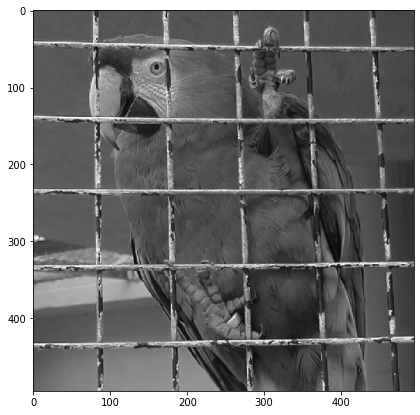

In [11]:
imgray = np.sum(imrgb,2)/3
plt.figure(figsize=(7, 7))
plt.imshow(imgray,cmap='gray',vmin=0,vmax=1)
plt.show()

Now use a custom weighted averaging of the three channels, that reflects better human perception:
$$I_{gs}=0.21R+0.72G+0.07B$$

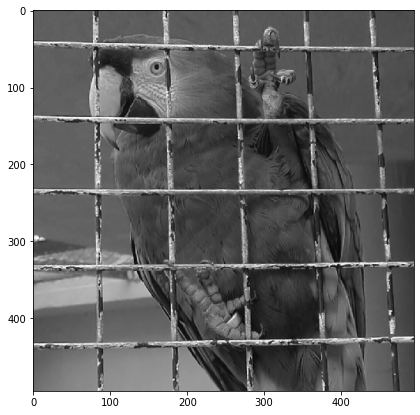

In [12]:
imgray2 = 0.21*imrgb[:,:,0] + 0.72*imrgb[:,:,1] + 0.07*imrgb[:,:,2]
# you can also do: imgray2 = np.average(imrgb,axis=2,weights=[0.21,0.71,0.07])
plt.figure(figsize=(7, 7))
plt.imshow(imgray2,cmap='gray',vmin=0,vmax=1)
plt.show()

## Histograms and contrast enhancement

### Computing histograms

In the following, we compute and display the gray level histogram and the cumulative histogram of an image. 
 
The cumulative histogram of a discrete image $u$ is an increasing function defined on $\mathbb{R}$ by
$$H_u(\lambda)=\frac{1}{|\Omega|}\#{\{\textbf{x};\;u(\textbf{x})\leq \lambda\}}.$$
The histogram of $u$ is the derivative of $H_u$ in the sense of distributions.


1. We compute the histogram of the image `imrgb`

In [13]:
imhisto, bins = np.histogram(imgray, range=(0,1), bins = 256)
imhisto = imhisto/np.sum(imhisto)

2. We now compute the corresponding cumulative histogram thanks to the function `np.cumsum()`which cumulates the values of a vector from left to right.

In [14]:
imhistocum = np.cumsum(imhisto) 

3. We display the image, histogram and cumulative histogram

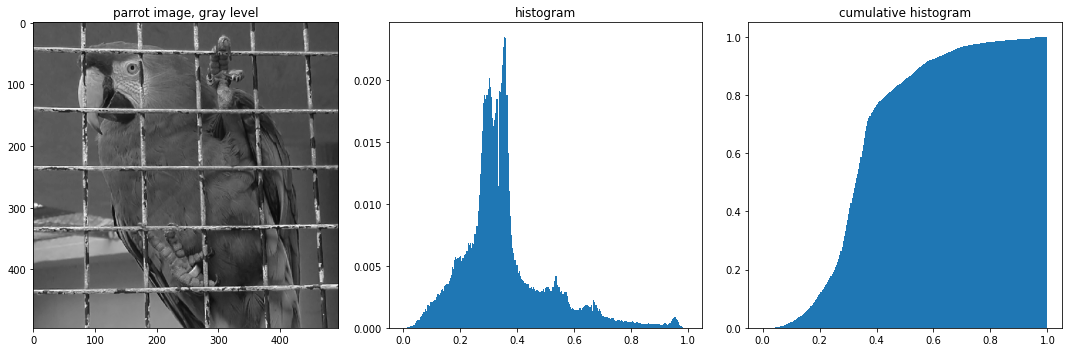

In [15]:
values = (bins[1:]+bins[:-1])/2
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
axes[0].imshow(imgray,cmap='gray',vmin=0,vmax=1)
axes[0].set_title('parrot image, gray level')
axes[1].bar(values,imhisto,width=1/256)
axes[1].set_title('histogram')
axes[2].bar(values,imhistocum,width=1/256)
axes[2].set_title('cumulative histogram')
fig.tight_layout()
plt.show()

### Histogram equalization 

If $u$ is a discrete image and $h_u$  its gray level distribution, histogram equalization consists in
applying a contrast change $g$ (increasing function) to $u$ such that $h_{g(u)}$ is as close as possible to a constant distribution. We can compute directly $$H_u(u)*255.$$

To this aim, we can apply directly the vector `imhistocum` (which can be seen as a function from $\{0,\dots,255\}$ into $[0,1]$) to the numpy array `imgray`. Since `imgray` has values between $0$ and $1$, it is necessary to multiply it by $255$ and cast it as a 8-bit array. 

In [16]:
imeq = imhistocum[np.uint8(imgray*255)]

We can now display the resulting equalized image.

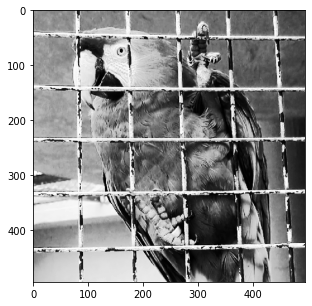

In [17]:
plt.figure(figsize=(5, 5))
plt.imshow(imeq,cmap = 'gray',vmin=0,vmax=1)
plt.show()

Compute and plot also the corresponding histograms and cumulative histograms of the equalized image.

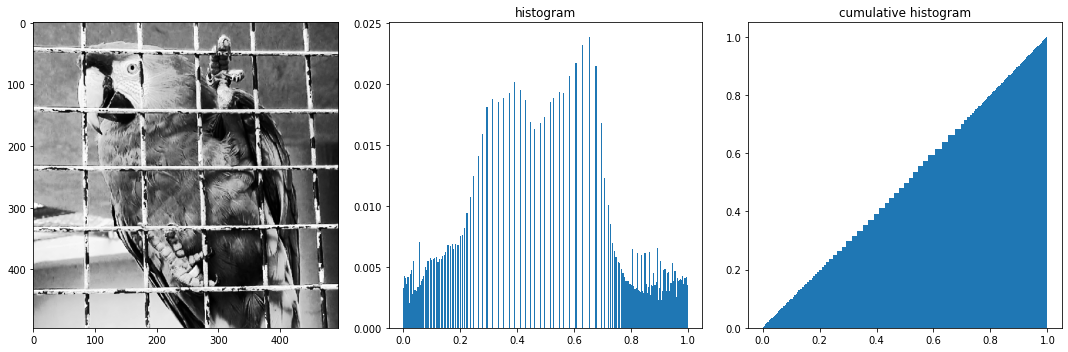

In [18]:
def comp_histos(im):
    imhisto, bins = np.histogram(im, range=(0,1), bins = 256)
    imhisto       = imhisto/np.sum(imhisto)
    imhistocum = np.cumsum(imhisto) 
    return imhisto, bins, imhistocum

def plot_histos(im):
    imhisto, bins, imhistocum = comp_histos(im)
    values = (bins[1:]+bins[:-1])/2
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    axes[0].imshow(im,cmap='gray',vmin=0,vmax=1)
    axes[1].bar(values,imhisto,width=1/256)
    axes[1].set_title('histogram')
    axes[2].bar(values,imhistocum,width=1/256)
    axes[2].set_title('cumulative histogram')
    fig.tight_layout()
    plt.show()

plot_histos(imeq)

**Now, apply the previous histogram equalization to the two images `parrot_bright` and `parrot_dark`, plot the corresponding histograms and cumulative histograms. Comment the results and explain the observed differences.** 

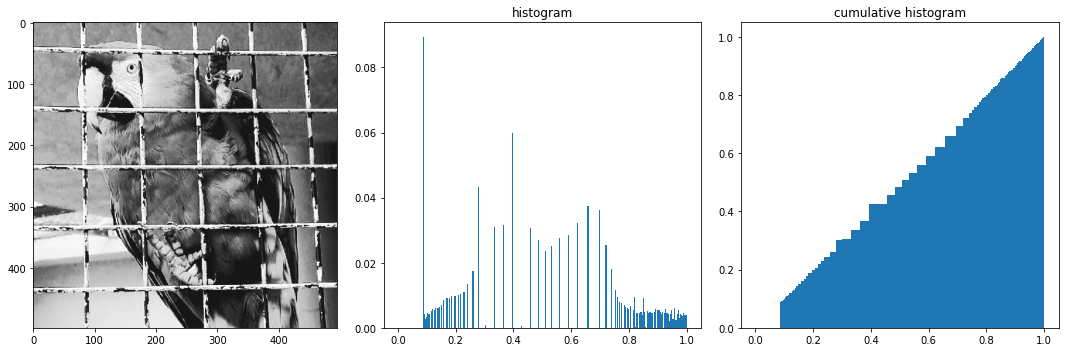

In [19]:
os.system("wget -c https://raw.githubusercontent.com/judelo/notebooks/master/im/parrot_bright.png")
os.system("wget -c https://raw.githubusercontent.com/judelo/notebooks/master/im/parrot_dark.png")
imrgb1 = plt.imread('parrot_bright.png')
imrgb2 = plt.imread('parrot_dark.png')

def rgbToGray (imrgb):
    imgray = 0.21*imrgb[:,:,0] + 0.72*imrgb[:,:,1] + 0.07*imrgb[:,:,2]
    return imgray

def todo_equalization (imrgb):
    imgray = rgbToGray(imrgb)
    imhisto, bins, imhistocum = comp_histos(imgray)
    imeq = imhistocum[np.uint8(imgray*255)]
    return imeq

imeq1,imeq2 = todo_equalization(imrgb1), todo_equalization(imrgb2)
plot_histos(imeq1)
plot_histos(imeq2)

### Histogram specification

If $u$ is a discrete image and $h_u$  its gray level distribution, histogram specification consists in  applying a contrast change $g$ (an increasing function) to $u$ such that $h_{g(u)}$ is as close as possible to a target discrete   probability distribution $h_t$. Specification is particularly useful to compare two images of the same scene (in this case the target distribution is the histogram of the second image $v$). 

We start by reading our two images $u$ and $v$.

In [20]:
os.system("wget -c https://raw.githubusercontent.com/storimaging/Images/main/img/buenosaires3.png")
os.system("wget -c https://raw.githubusercontent.com/storimaging/Images/main/img/buenosaires4.png")
buenos1=plt.imread('buenosaires3.png')
buenos2=plt.imread('buenosaires4.png')
v = buenos1[:,:,0]
u = buenos2[:,:,1]
[nrowu,ncolu]=u.shape
[nrowv,ncolv]=v.shape

1. Now, histogram specification between two grey level images $u$ and $v$ can be computed easily by sorting the pixels of both images and by replacing each gray level in $u$ by the gray level of similar rank in $v$.

In [21]:
u_sort,index_u=np.sort(u,axis=None),np.argsort(u,axis=None)
[v_sort,index_v]=np.sort(v,axis=None),np.argsort(v,axis=None)
uspecifv= np.zeros(nrowu*ncolu)
uspecifv[index_u] = v_sort
uspecifv = uspecifv.reshape(nrowu,ncolu)

We can now display the result.

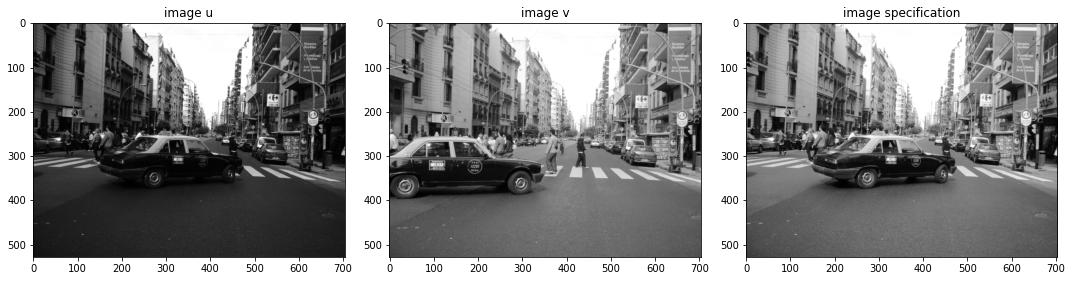

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
axes[0].set_title('image u')
axes[0].imshow(u,'gray')
axes[1].set_title('image v')
axes[1].imshow(v,'gray')
axes[2].set_title('image specification')
axes[2].imshow(uspecifv,'gray')
fig.tight_layout()
plt.show()

**2. Try to translate the grey levels of $u$ such that it has the same mean grey level than $v$ and display the result. Is it similar to the specification of $u$ on $v$ ?** 

(528, 704)


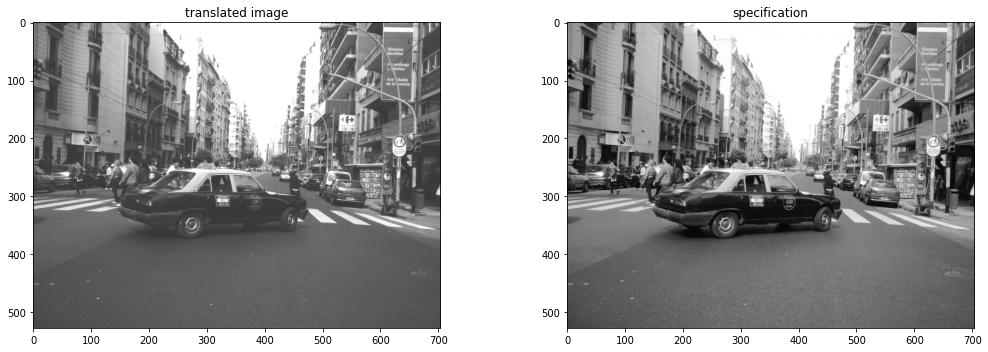

In [23]:
# First we compute the "translation value", i.e. the difference between the mean grey levels of the two images:
diff_mean_uv = np.mean(v-u)

# Now we apply the translation:
u_trans = u + diff_mean_uv

# The operation may have produced values outside the range [0,1], so we need to do a correction:
u_trans = np.maximum(0,np.minimum(1,u_trans))

print (u_trans.shape)

# We plot the resulting image, together with the specification of u on v:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].set_title('translated image')
axes[0].imshow(u_trans,'gray',vmin=0,vmax=1)
axes[1].set_title('specification')
axes[1].imshow(uspecifv,'gray',vmin=0,vmax=1)
fig.tight_layout()
plt.show()

**3. Same question by applying an affine transform to $u$ so that its mean and variance match the ones of $v$.** 

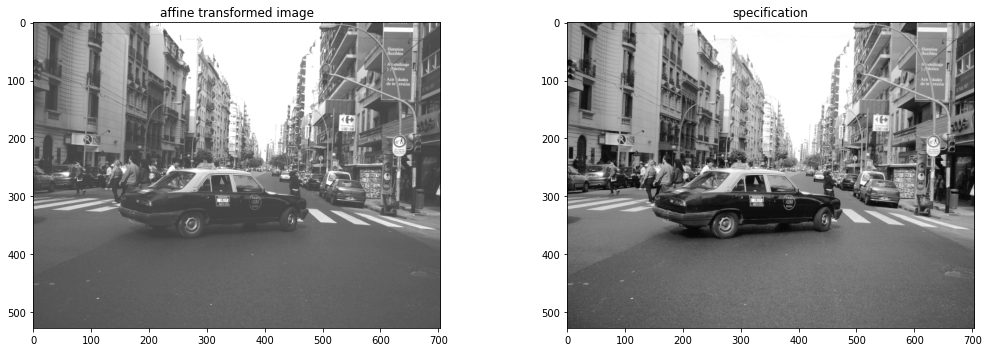

In [24]:
# We can first multiply u by the quotient of standard deviations between v and u, in order to get equal variances:
u_aff = u * (np.std(v)/np.std(u))

# Now we can do the same translation as previously:
u_aff = u_aff + np.mean(v-u_aff)

# Correction to fit in the range [0,1]:
u_aff = np.maximum(0,np.minimum(1,u_aff))

# We plot the resulting image, together with the specification of u on v:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].set_title('affine transformed image')
axes[0].imshow(u_aff,'gray',vmin=0,vmax=1)
axes[1].set_title('specification')
axes[1].imshow(uspecifv,'gray',vmin=0,vmax=1)
fig.tight_layout()
plt.show()


### Midway histogram 

The Midway histogram between two histograms $h_u$ et $h_v$ is defined from it cumulative function  $H_{midway}$ :
$$H_{midway}=\left( \frac{H_u^{-1}+H_v^{-1}}{2}\right)^{-1}.$$
The goal is to modify the contrast of both images $u$ and $v$ in order to give them the same intermediary grey level distribution.

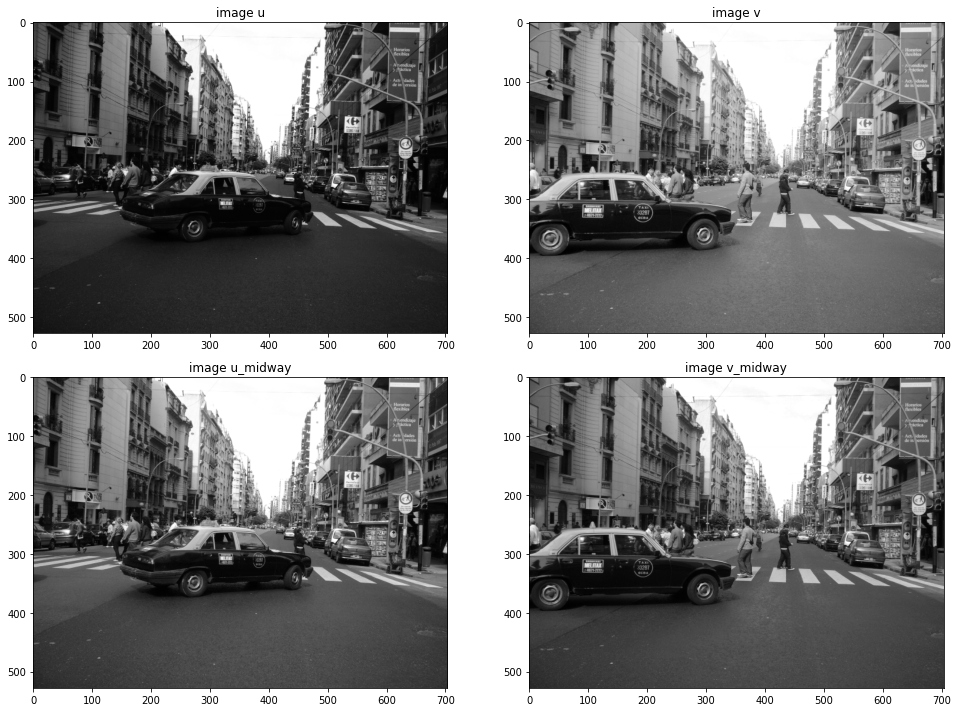

In [25]:
u_midway=np.zeros(len(index_u))
v_midway=np.zeros(len(index_v))

u_midway[index_u] = v_midway[index_v] = (u_sort + v_sort)/2

u_midway = u_midway.reshape(nrowu,ncolu)
v_midway = v_midway.reshape(nrowv,ncolv)

#Display the results
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
axes[0,0].set_title('image u')
axes[0,0].imshow(u,'gray')
axes[0,1].set_title('image v')
axes[0,1].imshow(v,'gray')
axes[1,0].set_title('image u_midway')
axes[1,0].imshow(u_midway,'gray')
axes[1,1].set_title('image v_midway')
axes[1,1].imshow(v_midway,'gray')
fig.tight_layout()
plt.show()

### Simple transformations

 In this exercice, you are asked to perform simple transformations on an image and find out what happens on the corresponding histogram : thresholding, affine transformation, gamma correction. 

### Effect of Noise on histograms
 
In the following, we want to create different noisy versions of an image $u$ and observe how the histogram $h_u$ is transformed.

**Gaussian noise** 

1. Write a function adding a gaussian noise $b$ to the image $u$. An image of gaussian noise of mean $0$ and of standard deviation $\sigma$ is obtained with the command 

        sigma*np.random.randn(nrow,ncol) 

2. Display the noisy image and its histogram for different values of $\sigma$. 
3. What do you observe ? What is the relation between the histogram of $u$ and the one of $u+b$ ? 

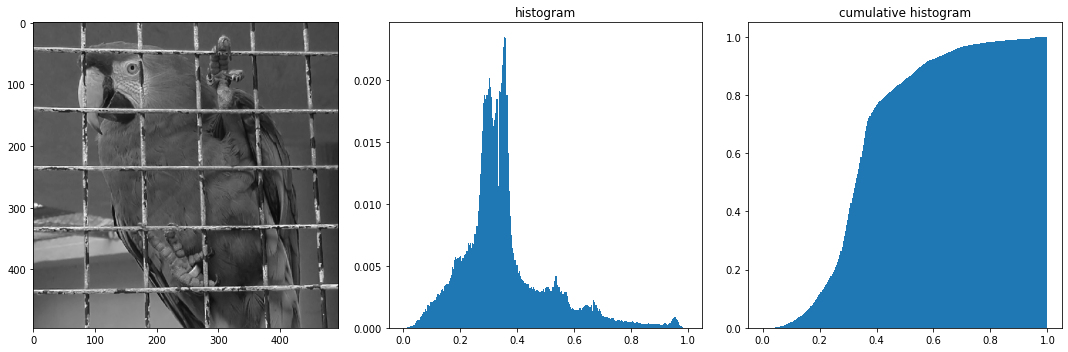

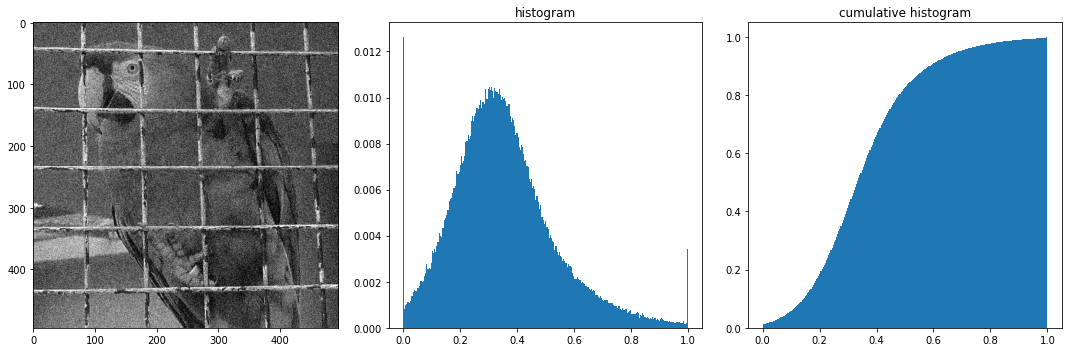

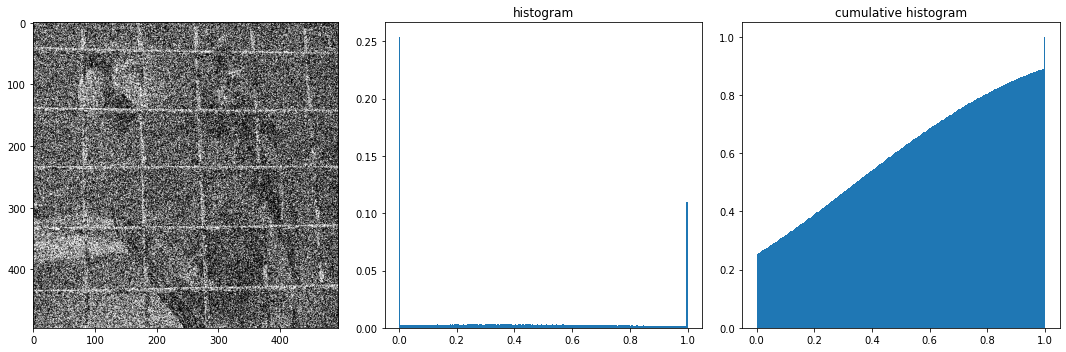

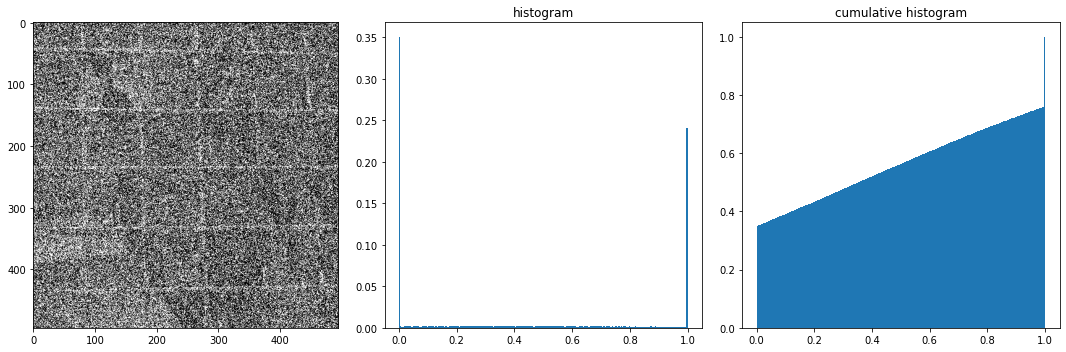

In [26]:
imgray = np.mean(plt.imread('parrot.png'),2)

plot_histos(imgray)

def todo_noise_histograms(u, sigma):
    nrow,ncol = u.shape
    b = sigma*np.random.randn(nrow,ncol)
    imnoise = u + b
    imnoise = np.maximum(0,np.minimum(1,imnoise))
    plot_histos(imnoise)  
    
todo_noise_histograms(imgray, 0.1)
todo_noise_histograms(imgray, 0.5)
todo_noise_histograms(imgray, 0.9)

**Uniform noise** Same questions with $b$ a uniform additive noise.

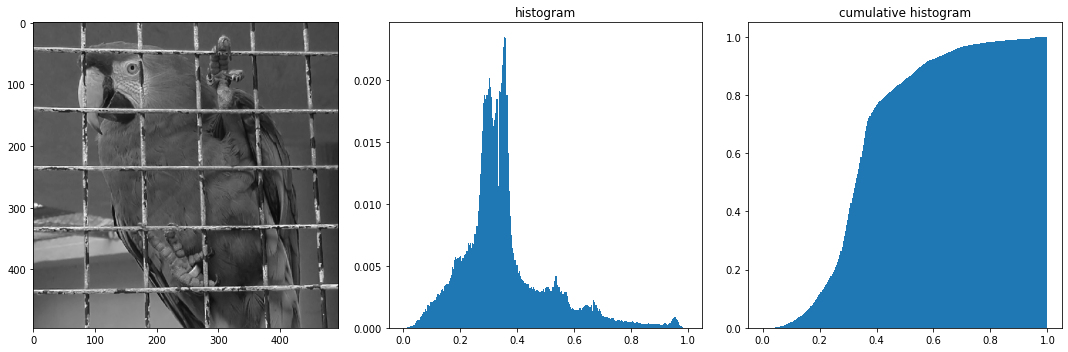

In [27]:
imgray = np.mean(plt.imread('parrot.png'),2)

plot_histos(imgray)

def todo_uniform_noise_histograms(u):
    nrow,ncol = u.shape
    b = np.random.uniform(size=(nrow,ncol))
    imnoise = u + b
    imnoise = np.maximum(0,np.minimum(1,imnoise))
    plot_histos(imnoise)
    
    
todo_uniform_noise_histograms(imgray)

**Impulse noise** Let us recall that impulse noise destroy randomly a proportion $p$ of the pixels in $u$ and replace their values by uniform random values between $0$ and $255$. Mathematically, this can be modeled as $u_b= (1-X)u+XY$, where $X$ follows a Bernouilli law of parameter $p$ and $Y$ follows a uniform law on $\{0,\dots 255\}$. 
     
1. Write a function adding impulse noise of parameter p to an image u.
*Hint* : you can start by using the function ~rand~ to create a table `tab` of random numbers following the uniform law on $[0,1]$ 
               
               tab = np.random.rand(u.shape[0],u.shape[1])
           
and then replace randomly $p\%$ of the pixels of $u$ by a random grey level

               ub = 255*np.random.rand(u.shape[0],u.shape[1])*(tab<p/100)+(tab>=p/100)*u;
               
2. Display the noisy image and its histogram for different values of p. What is the relation between the histogram of u and the one of u_b ?

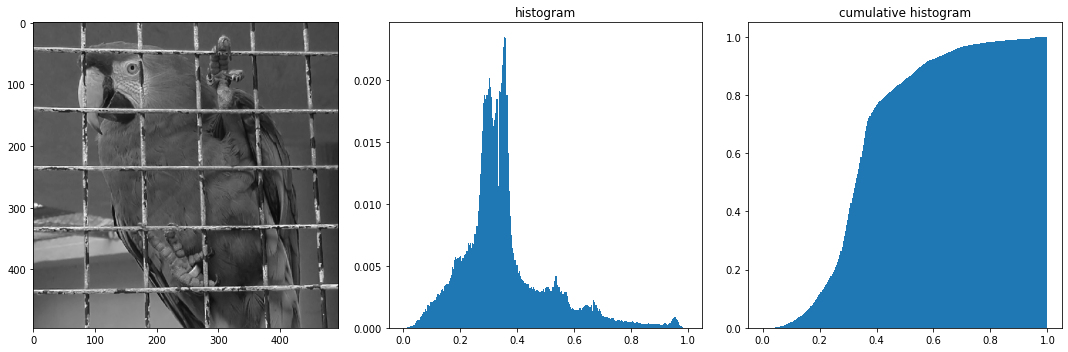

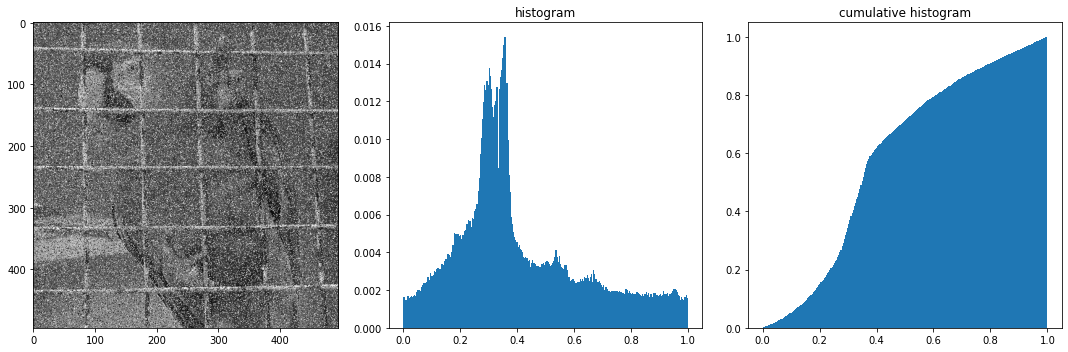

In [28]:
imgray = np.mean(plt.imread('parrot.png'),2)

def todo_impulse_noise_histograms(u, p):
    nrow,ncol = u.shape
    tab = np.random.uniform(size=(nrow,ncol))
    Y = np.random.rand(nrow,ncol)
    X = np.zeros((nrow,ncol))
    X[tab<p] = 1
    
    ub = (1-X)*u + X*Y
    plot_histos(ub)
    
plot_histos(imgray)    
todo_impulse_noise_histograms(imgray, 0.4)

## Image Quantization

### Quantization 

Image quantization consists in reducing the set of grey levels $Y = \{ y_0,\dots y_{n-1} \}$ or colors of an image $u$ into a smaller set of quantized values $\{q_0,\dots q_{p-1}\}$ ($p < n$). This operation is useful for displaying an image $u$ on a screen that supports a smaller number of colors (this is needed with a standard screen if $u$ is coded on more than 8 bits by channel).

A quantization operator $Q$ is defined by the values $(q_i)_{i=0, \dots p-1}$ and  $(t_j)_{j=0,\dots p}$ such that
$$ t_0 \leq q_0 \leq t_1 \leq q_1 \leq \dots q_{p-1} \leq t_p,\text{ and } Q(\lambda)=q_i \text{ if } t_i \leq \lambda < t_{i+1}.$$

 
*Uniform Quantization*
Uniform quantization consists in dividing the set $Y$ in $p$ regular intervals. 

- Use uniform quantization on a gray level image (try different numbers $K$ of grey levels) and display the result. For which value of $K$ do you start to see a difference with the original image ? 


In [29]:
os.system("wget -c https://raw.githubusercontent.com/storimaging/Images/main/img/simpson512.png")
u = np.mean(plt.imread('simpson512.png'),2)

# uniform quantization, several values of K
tabK = [50,30,20,10,5,2]
nK = len(tabK)
plt.figure(figsize=(16, 10))
for i, K in enumerate(tabK):
    u_quant = (np.floor(K*u)+.5)/K
    plt.subplot(2,int(np.ceil(nK/2)),i+1)
    plt.imshow(u_quant,cmap='gray',vmin=0,vmax=1)
plt.show()

*Histogram-based Quantization*
This consists in choosing $t_i=\min \{\lambda; H_u(\lambda) \geq \frac{i}{p} \}$, and the $q_i$ are defined as the barycenters of the intervals $[t_i,t_{i+1}].$

1. Show that this boils down to an histogram equalization followed by a uniform quantization, and applying $H_u^{-1}$ to the resulting image
2. Apply this quantization on a gray level image and display the result. Same question on the limit value $K$ for which we perceive a difference with the original image.

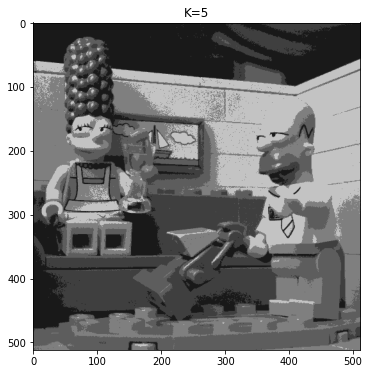

In [30]:
u = np.mean(plt.imread('simpson512.png'),2)
#K = 20

def todo_histogram_quantize2(u,K):
    imhisto, bins, imhistocum = comp_histos(u)
    imeq = imhistocum[np.uint8(u*255)]
    u_quant = (np.floor(K*imeq)+.5)/K
    return u_quant

# histogram quantization
plt.figure(figsize=(16, 10))
#tabK = [50,30,20,10,5,2]  # several values of K
tabK= [5]
nK = len(tabK)
for i, K in enumerate(tabK):
    im_quant = todo_histogram_quantize(u,K)
    plt.subplot(2,3,i+1)
    plt.title('K='+str(K))
    plt.imshow(im_quant,cmap='gray',vmin=0,vmax=1)
plt.tight_layout()
plt.show()

*Lloyd-Max quantization* 
This quantization consists in minimizing the least square error
$$LSE((q_i)_{i=1\dots p-1},(t_i)_{i=1\dots p})= \sum_{i=0}^{p-1} \int_{t_i}^{t_{i+1}} h(\lambda) (\lambda -q_i)^2.$$
It is equivalent to the algorithm `Kmeans` in one dimension.
   1. Write the optimality conditions that should be satisfied by the solution $\{(\widehat{q_i}),(\widehat{t_i})\}$.
   2. Write a function which minimizes the least square error by alternatively minimizing in $(q_i)_{i=0, \dots p-1}$ and  $(t_j)_{j=0,\dots p}$. 
   3. Apply this quantization on the previous gray level image for different values of $K$ and display the result. Comment.

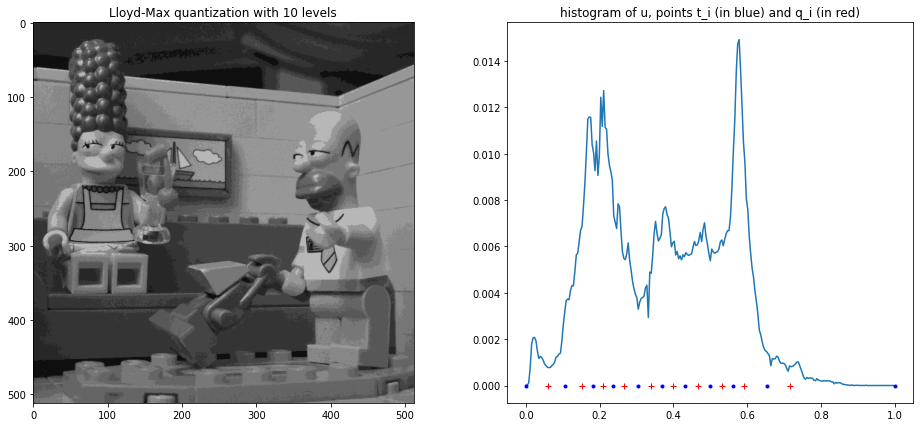

In [31]:
imgray  = np.mean(plt.imread('simpson512.png'),2)
u_quant = todo_Lloyd_Max_quantize(imgray,K=10,plot=True)

### Dithering

Dithering consists in adding intentionnally noise to an image before quantization. For instance, it can be used to convert a grey level image to black and white in such a way that the density of white dots in the new image is an increasing function of the grey level in the original image. This is particularly useful for impression or displaying.

Let us explain how dithering works in the case of 2 grey levels (binarization). All grey levels smaller than a value $\lambda$ are replaced by $0$ and those greater than $\lambda$ are replaced by $255$. If we add a i.i.d. noise $B$ of density $p_B$ to $u$ before the binarization, then at the pixel $x$ we get
$$P[u(x) + B(x) > \lambda]  = P[B(x) > \lambda - u(x) ] =   \int_{\lambda - u(x)}^{+\infty} p_B(s)ds,$$
which is an increasing function of the value $u(x)$. The probability that $x$ turns white in the dithered image is thus an increasing function of its original grey level. 

**Perform dithering in order to quantize a gray level image on 10 levels (you can add a small Gaussian noise of std 5/255 for instance). Compare the result with the previous quantizations without dithering.** 

**Try with different levels of noise.**


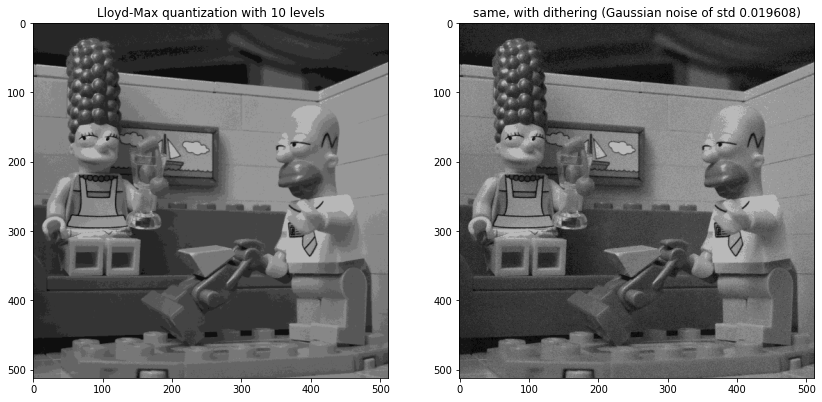

In [32]:
imgray = np.mean(plt.imread('simpson512.png'),2)
todo_dither(imgray,K=10,sigma=5/255)

In [33]:
os.system("wget -c https://raw.githubusercontent.com/storimaging/Images/main/img/lighthouse.bmp")
imgray   = np.mean(plt.imread('lighthouse.bmp'),2) / 255
todo_dither(imgray,K=2,sigma=10/255)

In [34]:
os.system("wget -c https://raw.githubusercontent.com/storimaging/Images/main/img/falaise.jpg")
imgray   = plt.imread('falaise.jpg') / 255
todo_dither(imgray,K=2,sigma=60/255)